In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")

# turn of data table rendering
pd.set_option('display.notebook_repr_html', False)
sns.set_palette(['#00A99D', '#F5CA0C', '#B6129F', '#76620C', '#095C57'])
sys.version

'3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]'

## Testing Multiple Independent Samples
If we want to test for significance in mean differences between more than two independent samples, we would have to perform a lot of t-tests. If, for example, we have 6 independent samples, we must conduct 15 t-tests to know what samples significantly differ from each other, as shown here in the binomial:

$$
\binom{n}{2}=\frac{n!}{2!(n-2)!}=\frac{6\cdot5\cdot4\cdot3\cdot2\cdot1}{(2\cdot1)\cdot(4\cdot3\cdot2\cdot1)}=\frac{6\cdot5}{2}=\frac{30}{2}=15
$$


That's a lot of, and even unnecessary, work. That's where ANOVA comes in. With Analysis of Variance we can test multiple independent sample sets to see if there is a significant difference between at least two samples. 

## Case
A manufacturer of electric guitar strings 'Olixir', claims to have the longest sustaining tone in the market. They conducted a comparitive test with a group of three competing brands. The guitar used in the test was the same for all tests. All strings were plucked by the same person, with the same technique and performed a number of times. The tone sustain length is measured in milliseconds. The resulting data set looks like this:

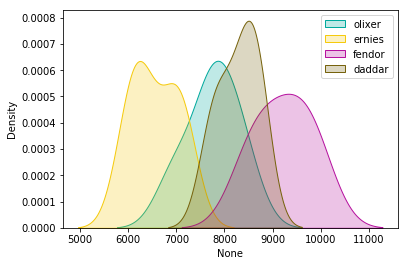

In [2]:
# The four sample sets with guitar string sustain lengths
olixir = np.array([8021., 6947., 8411., 7593., 7781.])
ernies = np.array([7013., 6222., 7202., 6437., 5946., 6917., 6152.])
fendor = np.array([9896., 9497., 8986., 8496.])
daddar = np.array([8253., 8467., 7898., 7699., 8738., 8638.])

# Construct kernel density estimate plot
sns.kdeplot(olixir, label='olixer', shade=True)
sns.kdeplot(ernies, label='ernies', shade=True)
sns.kdeplot(fendor, label='fendor', shade=True)
sns.kdeplot(daddar, label='daddar', shade=True)

plt.legend()
plt.show()

## Grand Mean
We can compare three or more samples by finding the average squared deviation of each sample from the [grand mean](http://en.wikipedia.org/wiki/Grand_mean) of all sample groups $\bar{\bar{x}}$. The grand mean is calculated by taking all sample values and divide them by the number of samples (where $k$ is the number of groups and $n$ is the number of observations in a group and $x$ is single sample).

$$
\bar{\bar{x}}=\frac{1}{kn}\sum_{k}\sum_{n}x
$$

## Hypothesis
While Fendor seems to have the highest mean average tone sustain, is the difference compared to the other samples statistical significant or due to random chance? We state our hypothesis: If there is no statistical significant difference between any of the tested guitar strings brands at an alpha level of .05, then we fail to reject the null hypothesis.

|Hypothesis|$\alpha = .05$||
|---:|:---:|---|:---|
|$H_0:$|$\mu_o = \mu_e = \mu_f = \mu_d$|There is no significant difference between any of the brands|
|$H_a:$|$\mu_o \neq \mu_e \neq \mu_f \neq \mu_d$|There is a significant difference between at least two brands|

In [3]:
# Calculate the grand mean and sample group means
N = np.concatenate([olixir, ernies, fendor, daddar]).size
xbar_grand = np.concatenate([olixir, ernies, fendor, daddar]).mean()

print(xbar_grand)

7782.272727272727


In [4]:
# Calculate the group means
xbar_olixir = olixir.mean()
xbar_ernies = ernies.mean()
xbar_fendor = fendor.mean()
xbar_daddar = daddar.mean()

print(xbar_olixir, xbar_ernies, xbar_fendor, xbar_daddar, sep='\n')

7750.6
6555.571428571428
9218.75
8282.166666666666


## ANOVA
The [One-way Analysis of Variance](http://en.wikipedia.org/wiki/One-way_analysis_of_variance) results in a test statistic (F) which is a ratio of the 'between-group variability' and the 'within-group variability'. The between-group variability denotes the distance the group means have from each other, while the within-group variability is a measure of how wide or skinny the distribution of a group is. The larger the variance the wider the distribution.

## Between-group Variability
To calculate the between-group variability we take mean difference of each sample (SSB) in relation to the grand mean. We multiple the number of groups times the sum of the differences between the group mean and grand mean, squared:

$$
\sum n_k(\bar{x}_k-\bar{\bar{x}})^2
$$

In [5]:
# Calculate the sum of squares between groups (SSB)
ssb_olixir = len(olixir) * np.square(xbar_olixir - xbar_grand)
ssb_ernies = len(ernies) * np.square(xbar_ernies - xbar_grand)
ssb_fendor = len(fendor) * np.square(xbar_fendor - xbar_grand)
ssb_daddar = len(daddar) * np.square(xbar_daddar - xbar_grand)

SSB = (ssb_olixir + ssb_ernies + ssb_fendor + ssb_daddar)
print(SSB)

20291819.866017316


## Within-group Variability
To calculate the within-group variability we take the sum of squares of each sample point in relation to the group mean (SSW). We sum up these differences, squared:

$$
\sum(x_i-\bar{x}_k)^2
$$

In [6]:
# Calculate the sum of squares within groups (SSW)
ssw_olixir = np.square(olixir - xbar_olixir).sum()
ssw_ernies = np.square(ernies - xbar_ernies).sum()
ssw_fendor = np.square(fendor - xbar_fendor).sum()
ssw_daddar = np.square(daddar - xbar_daddar).sum()

SSW = ssw_olixir + ssw_ernies + ssw_fendor + ssw_daddar
print(SSW)

4568010.497619047


## F-statistic
Now we have the sum of squares for both within-group and between-group, we can calculate the F-statistic. For this we need the degrees of freedom for between-groups (k-1) and within-groups (N-k). We then calculate the mean square between groups (MSB) and the mean square within groups (MSW). The complete formula for calculating the F-statistic is shown here:

$$
F=\frac{\sum n_k(\bar{x}_k-\bar{\bar{x}})^2/(k-1)}{\sum(x_i-\bar{x}_k)^2/(N-k)}=\frac{SSB/dfB}{SSW/dfW}=\frac{MSB}{MSW}
$$


In [7]:
# Calculate the degrees of freedom
k = 4        # Number of sample groups
dfB = k - 1  # Degrees of freedom between groups
dfW = N - k  # Degrees of freedom within groups
print(dfB, dfW, sep=', ')

3, 18


In [8]:
# Calculate the Mean squared difference
MSB = SSB / dfB 
MSW = SSW / dfW 
print(MSB, MSW, sep='\n')

6763939.955339105
253778.36097883593


In [9]:
# Calculate the F-statistic
F = MSB / MSW
print(F)

26.65294207611022


## Hypothesis Testing
We test the hypothesis by comparing the calculated f-statistic against the F-critical value for an alpha level and the degreed of freedom between and within groups. The F-test is always a one-sided test against an alpha level on the F-distribution.

In [10]:
# Find the F-critical value for alpha level .05
F_critical = stats.distributions.f.ppf(1 - .05, dfB, dfW)
print(F_critical)

3.1599075898007243


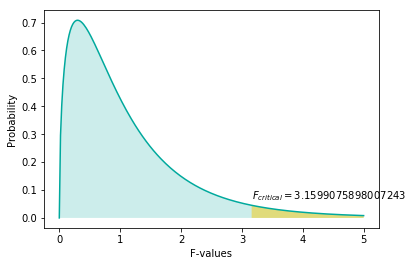

In [11]:
# Plot the F-Distribution for dfB and dfW
x_plot = np.linspace(0, 5, 250)
y_plot = stats.distributions.f.pdf(x_plot, dfB, dfW)
plt.fill_between(x_plot, y_plot, alpha=.2)
plt.plot(x_plot, y_plot)

# Plot the F-critical value at alpha .05
x_fcrit = np.linspace(F_critical, 5, 250)
y_fcrit = stats.distributions.f.pdf(x_fcrit, dfB, dfW)
plt.fill_between(x_fcrit, y_fcrit, alpha=.5)
plt.text(F_critical, .07, '$F_{critical}=$'+str(F_critical))
plt.xlabel('F-values')
plt.ylabel('Probability')
plt.show()

In [12]:
# Test the null hypothesis
F < F_critical

False

Since the F-statistic is (much) larger than the F-critical value, we reject the null hypothesis. At least two of the sample groups tested are have a significant different mean.

## ANOVA with f_oneway
All the calculations shown here can be efficiently done by calling [scipy stats f_oneway](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html), given the sample groups. The function returns the F-statistic as well as the p-value.

In [13]:
# One-way ANOVA the convenient way
f_value, p_value = stats.f_oneway(olixir, ernies, fendor, daddar)
print(f_value)
print(p_value)

26.652942076110193
7.687999312604955e-07


In [14]:
# Null hypothesis test at alpha level .05
p_value > .05

False

## ANOVA Table
We often use and encounter [analysis of variance tables](https://onlinecourses.science.psu.edu/stat414/node/218) like this one to report our findings.

|Source|DF|SS|MS|F|P|
|:---|---:|---:|---:|---:|---:|
|Factor|3|20291819.866|6763939.955|26.653|7.688e-07|
|Error|18|4568010.498|253778.361|||
|Total|21|24859830.364||||

## Eta Squared
The effect size used to interpret the outcome of the ANOVA is called [eta squared](http://en.wikiversity.org/wiki/Eta-squared) $\eta^2$. This value is the proportion of the difference due to a treatment, in this case the guitar string brand. Like $r^2$, we use $\eta^2$ to denote how much of the difference in means is explained by the input variable. Eta squared is calculated as follows:

$$
\eta^2=\frac{\sum n_k(\bar{x}_k-\bar{\bar{x}})^2}{\sum n_k(\bar{x}_k-\bar{\bar{x}})^2+\sum(x_i-\bar{x}_k)^2}=\frac{SSB}{SSB+SSW}
$$

In [15]:
# Calculate eta squared
eta_squared = SSB / (SSB + SSW)
print(eta_squared)

0.8162493295086642


This value points out that approximately 82% of the guitar string tone sustain can be explained by the different guitar brands.

## Tukey's HSD
We can use Tukey's Honnestly Significant Difference ([Tukey-kramer HSD](http://en.wikipedia.org/wiki/Tukey%27s_range_test)) to find out which of the sample groups have a significant difference in relation to the other sample groups. To do this, we need to construct a single data set with all the observations and group labels.

In [16]:
# Construct single dataset for Tukey-kramer HSD test
x1 = pd.DataFrame(olixir, columns=['observation'])
x1['grouplabel'] = 'olixer'
x2 = pd.DataFrame(ernies, columns=['observation'])
x2['grouplabel'] = 'ernies'
x3 = pd.DataFrame(fendor, columns=['observation'])
x3['grouplabel'] = 'fendor'
x4 = pd.DataFrame(daddar, columns=['observation'])
x4['grouplabel'] = 'daddar'

data = x1.append(x2).append(x3).append(x4)
data.head()

   observation grouplabel
0       8021.0     olixer
1       6947.0     olixer
2       8411.0     olixer
3       7593.0     olixer
4       7781.0     olixer

In [17]:
result = sm.stats.multicomp.pairwise_tukeyhsd(data.observation, data.grouplabel)
print(result.summary())

 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper   reject
----------------------------------------------------
daddar ernies -1726.5952 -2518.7099 -934.4805  True 
daddar fendor  936.5833   17.5412   1855.6255  True 
daddar olixer -531.5667  -1393.7046  330.5713 False 
ernies fendor 2663.1786   1770.781  3555.5761  True 
ernies olixer 1195.0286   361.3519  2028.7052  True 
fendor olixer  -1468.15  -2423.2466 -513.0534  True 
----------------------------------------------------


In [18]:
# The labels for group 0 to 3 respectively
print(result.groupsunique)

['daddar' 'ernies' 'fendor' 'olixer']


It seems that only in the case of 'Daddar' and 'Olixir' we can state that their sample means are *not* significantly different at this familywise error rate (FWER=.05). In this case we fail to reject the null hypothesis. In all other cases we reject $H_0$ in favor of the alternative hypothesis.